In [39]:
from qiskit import *
from qiskit.providers.aer import noise
import qiskit.quantum_info as qi

sim = Aer.get_backend("qasm_simulator")

import numpy as np
from matplotlib import pyplot as plt

In [13]:
q_comp = QuantumRegister(2, 'q_comp')
q_leak = QuantumRegister(1, 'q_leak')
c_comp = ClassicalRegister(2, 'c_comp')
c_leak = ClassicalRegister(1, 'c_leak')

qc = QuantumCircuit(q_comp, q_leak, c_comp, c_leak)
qc.h(q_comp[0])
qc.h(q_comp[1])
qc.barrier(q_comp, q_leak)
qc.h(q_comp[0])
qc.h(q_comp[1])
qc.draw()

qc0 = qc.copy()
qc0.measure(q_comp, c_comp)
qc0.barrier(q_comp, q_leak)
qc0.measure(q_leak, c_leak)

qc1 = qc.copy()
qc1.x(q_comp[0])
qc1.measure(q_comp, c_comp)
qc1.barrier(q_comp, q_leak)
qc1.measure(q_leak, c_leak)

qc2 = qc.copy()
qc2.x(q_comp[1])
qc2.measure(q_comp, c_comp)
qc2.barrier(q_comp, q_leak)
qc2.measure(q_leak, c_leak)

qc3 = qc.copy()
qc3.x(q_comp[0])
qc3.x(q_comp[1])
qc3.measure(q_comp, c_comp)
qc3.barrier(q_comp, q_leak)
qc3.measure(q_leak, c_leak)

qc_all = [qc0, qc1, qc2, qc3]


In [14]:
qc0.draw()

In [15]:
qc1.draw()

In [16]:
qc2.draw()

In [17]:
qc3.draw()

In [22]:
lrb_circs = transpile(qc_all, basis_gates=['u3', 'cx'], optimization_level=3)

## Define the leakage noise model

In [23]:
def leakage_error(qubit_error, p_leakage):
    no_leak = qi.Choi(qubit_error).expand(qi.Operator([[1,0], [0, 1]]))
    leak = qi.Choi(qubit_error).expand(qi.Operator([[0,1],[1,0]]))
    
    return (1 - p_leakage) * no_leak + p_leakage * leak

p_depol1 = 0.01
p_depol2 = 0.01
p_leakage1 = 0.1
p_leakage2 = 0.1
error_1q_leakage = leakage_error(noise.errors.depolarizing_error(p_depol1, 1), p_leakage1)
error_2q_leakage = leakage_error(noise.errors.depolarizing_error(p_depol2, 2), p_leakage2)

nm = noise.NoiseModel()
nm.add_nonlocal_quantum_error(error_1q_leakage, ['u1', 'u2', 'u3'], [0], [0, 2])
nm.add_nonlocal_quantum_error(error_1q_leakage, ['u1', 'u2', 'u3'], [1], [1, 2])
nm.add_nonlocal_quantum_error(error_2q_leakage, ['cx'], [0, 1], [0, 1, 2])
nm.add_nonlocal_quantum_error(error_2q_leakage, ['cx'], [1, 0], [1, 0, 2])
print(nm)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1', 'cx']
  Qubits with noise: [0, 1, 2]
  Non-local specific qubit errors: [('u1', [0], [0, 2]), ('u1', [1], [1, 2]), ('u2', [0], [0, 2]), ('u2', [1], [1, 2]), ('u3', [0], [0, 2]), ('u3', [1], [1, 2]), ('cx', [0, 1], [0, 1, 2]), ('cx', [1, 0], [1, 0, 2])]


## Run on noisy simulator and check the result!

In [24]:
shots = 5000
result = execute(lrb_circs, sim, shots=shots, noise_model=nm).result()

counts0 = result.get_counts(0)
counts1 = result.get_counts(1)
counts2 = result.get_counts(2)
counts3 = result.get_counts(3)
print(counts0)
print(counts1)
print(counts2)
print(counts3)

{'0 01': 32, '1 10': 9, '1 00': 1424, '0 10': 41, '1 01': 19, '0 00': 3475}
{'0 01': 3495, '0 10': 1, '1 00': 13, '0 11': 31, '1 01': 1408, '1 11': 8, '0 00': 44}
{'1 10': 1471, '0 10': 3431, '1 00': 4, '0 11': 36, '1 11': 16, '0 00': 42}
{'0 01': 25, '1 10': 22, '0 10': 35, '1 00': 2, '0 11': 3459, '1 01': 7, '1 11': 1450}


In [25]:
## Caluculate the Potulation the 

In [26]:
p00 = counts0.get('0 00', 0) / shots
p01 = counts1.get('0 00', 0) / shots
p10 = counts2.get('0 00', 0) / shots
p11 = counts3.get('0 00', 0) / shots
p_id = p00 + p01 + p10 + p11
p_id

0.7121999999999999

In [32]:
nm_list = []
for error in range(10):

    p_leakage1 = error*0.01
    p_leakage2 = error*0.1
    error_1q_leakage = leakage_error(noise.errors.depolarizing_error(p_depol1, 1), p_leakage1)
    error_2q_leakage = leakage_error(noise.errors.depolarizing_error(p_depol2, 2), p_leakage2)

    nm = noise.NoiseModel()
    nm.add_nonlocal_quantum_error(error_1q_leakage, ['u1', 'u2', 'u3'], [0], [0, 2])
    nm.add_nonlocal_quantum_error(error_1q_leakage, ['u1', 'u2', 'u3'], [1], [1, 2])
    nm.add_nonlocal_quantum_error(error_2q_leakage, ['cx'], [0, 1], [0, 1, 2])
    nm.add_nonlocal_quantum_error(error_2q_leakage, ['cx'], [1, 0], [1, 0, 2])
    
    nm_list.append(nm)

In [34]:
pid_list = []
for nm in nm_list:
    shots = 5000
    result = execute(lrb_circs, sim, shots=shots, noise_model=nm).result()

    counts0 = result.get_counts(0)
    counts1 = result.get_counts(1)
    counts2 = result.get_counts(2)
    counts3 = result.get_counts(3)
    
    p00 = counts0.get('0 00', 0) / shots
    p01 = counts1.get('0 00', 0) / shots
    p10 = counts2.get('0 00', 0) / shots
    p11 = counts3.get('0 00', 0) / shots
    p_id = p00 + p01 + p10 + p11
    pid_list.append(p_id)

In [41]:
print(pid_list)

[0.9972, 0.9536, 0.929, 0.882, 0.8578000000000001, 0.8353999999999999, 0.7918000000000001, 0.7708, 0.7478, 0.7353999999999999]


ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

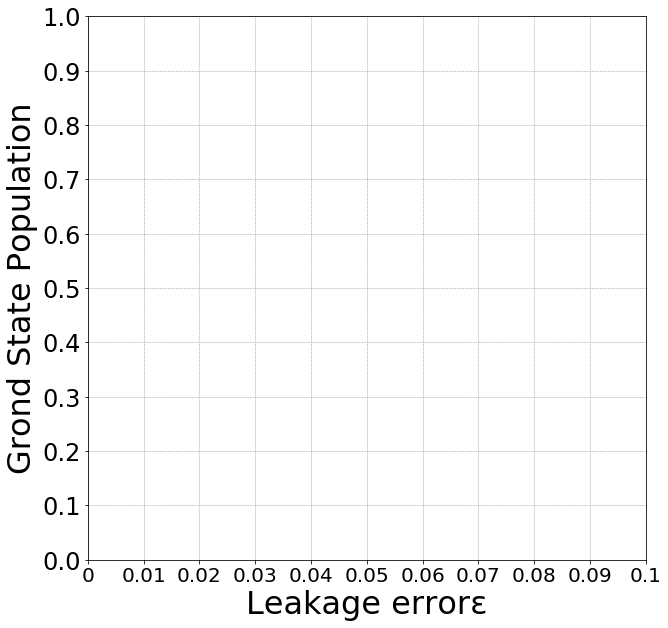

In [40]:
fig,ax = plt.subplots(figsize=(10, 10))


## set grid
ax.grid(which = "major", axis = "y", color = "gray", alpha = 0.8, linestyle = "--", linewidth = 0.5)
ax.grid(which = "major", axis = "x", color = "gray", alpha = 0.8, linestyle = "--", linewidth = 0.5)

## set axis
plt.ylabel("Grond State Population", fontsize= 32)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticklabels(["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"], 
                   fontsize= 24)
plt.ylim(0,1)


plt.xlabel("Leakage errorε", fontsize= 32)
ax.set_xticks(np.linspace(0, 0.1, 11))

ax.set_xticklabels(["0", "0.01", "0.02", "0.03", "0.04", "0.05", "0.06", "0.07", "0.08", "0.09", "0.1"],
                   fontsize= 20)
x_ax = np.linspace(0, 0.1, 11)
plt.xlim(0,0.1)


## data
plt.plot(x_ax, pid_list, color='#EF5350', )